# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# [1]. Reading Data

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect(r"D:\AppliedAI\AAIC_Course_handouts\11_Amazon Fine Food Reviews\amazon-fine-food-reviews\database.sqlite")
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())


100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 4032.63it/s]


In [23]:
preprocessed_reviews[3]
type(preprocessed_reviews)

list

<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.
##Name:PrateekSaurabh (Just for identification)

import pandas as pd
import numpy as np
import sqlite3
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from tqdm import tqdm_notebook as tqdm


con = sqlite3.connect(r"D:\AppliedAI\AAIC_Course_handouts\11_Amazon Fine Food Reviews\amazon-fine-food-reviews\database.sqlite")
data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""",con)

# Change Score with 1 n 2 as -ve and 4 n 5 as +ve

def chng_to_0_or_1 (Score):
    if Score ==4 or Score ==5:
        return 1
    elif Score ==1 or Score ==2:
        return 0
    else:# Thus in case by some mistake any data is their with rating 6 or 7 etc due to some error is removed
        pass
currentScore = data["Score"]
new_Score = currentScore.map(chng_to_0_or_1)
data["Score"] = new_Score
print ("Number of data points available")
print (data.shape)#Gives original number of data points available


#2 Data Cleaning a.) Getting rid of duplicates and b.) if helpnessdenominator < helpfulnessnumerator


data = data.drop_duplicates(subset = ["UserId","ProfileName","HelpfulnessNumerator","HelpfulnessDenominator","Score","Time","Summary","Text"], keep='first', inplace=False)
print ("Number of data points after removing duplicates")
print (data.shape)#Gives data points are deduplication

# Reference: Copied from above cell  final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
data=data[data.HelpfulnessNumerator<=data.HelpfulnessDenominator]
print ("Number of data points after removing where HelpfulnessNumerator is more than HelpfulnessDenominator ")
print (data.shape)
#Lets reduce data to 6K points
data = data.head(6000)
print ("After removing good chunk of data and taking first 6K data points")
print (data.shape)



#3 Preprocessing begins

#Convert to lower case,convert shortcut words to proper words, remove Special Character

#i) Convert to lower case:
data["Summary"] =  (data["Summary"].str.lower())

#ii) Convert Shortcuts words to proper words
#List of Words are:https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
#Reference:https://stackoverflow.com/questions/39602824/pandas-replace-string-with-another-string
data['Summary'] = data['Summary'].replace({"ain't":"am not","amn't":"am not","aren't":"are not", \
"can't":"cannot","cause":"because","could've":"could have","couldn't":"could not","couldn't've":"could not have", \
"daren't":"dare not","daresn't":"dare not","dasn't":"dare not","didn't":"did not","doesn't":"does not", \
"don't":"do not","e'er":"ever","everyone's":"everyone is","finna":"fixing to","gimme":"give me", \
"gonna":"going to","gon't":"go not","gotta":"got to","hadn't":"had not","hasn't":"has not","haven't":"have not",\
"he'd":"he had","he'll":"he shall","he's":"he has","he've":"he have","how'd":"how did","how'll":"how will",\
"how're":"how are","how's":"how has","I'd":"I had","I'll":"I shall","I'm":"I am","I'm'a":"I am about to",\
"I'm'o":"I am going to","I've":"I have","isn't":"is not","it'd":"it would","it'll":"it shall","it's":"it has",\
"let's":"let us","mayn't":"may not","may've":"may have","mightn't":"might not","might've":"might have",\
"mustn't":"must not","mustn't've":"must not have","must've":"must have","needn't":"need not","ne'er":"never",\
"o'clock":"of the clock","o'er":"","ol'":"old","oughtn't":"ought not","shalln't":"shall not","shan't":"shall not",\
"she'd":"she had","she'll":"she shall","she's":"she is","should've":"should have","shouldn't":"should not",\
"shouldn't've":"should not have","somebody's":"somebody has","someone's":"someone has","something's":"something has",\
"that'll":"that will","that're":"that are","that's":"that is","that'd":"that would","there'd":"there had",\
"there'll":"there shall","there're":"there are","there's":"there is","these're":"hese are","they'd":"they had",\
"they'll":"they will","they're":"they are","they've":"they have","this's":"","those're":"those are","tis":"it is",\
"twas":"it was","wasn't":"was not","we'd":"we had","we'd've":"we would have","we'll":"we will","we're":"we are",\
"we've":"we have","weren't":"were not","what'd":"what did","what'll":"what will","what're":"what are","what's":"what is",\
"what've":"what have","when's":"when is","where'd":"where did","where're":"where are","where've":"where have",\
"which's":"which has","who'd":"who would","who'd've":"who would have","who'll":"who shall","who're":"who are",\
"who's":"who has","who've":"who have","why'd":"why did","why're":"why are","why's":"why has","won't":"will not",\
"would've":"would have","wouldn't":"would not","y'all":"you all","you'd":"you had","you'll":"you shall","you're":"you are",\
"you've":"you have"})
# iii) Remove Special Characters except alpahbets and numbers
#Ref:https://stackoverflow.com/questions/33257344/how-to-remove-special-characers-from-a-column-of-dataframe-using-module-re
data["Summary"]=data["Summary"].map(lambda x: re.sub(r'[^a-zA-Z_0-9 ]', '', x))
#The Summary are usually so small if we remove few stopwords the meaning itself would be complely lost or chamge
# So let us see what all stopwords we have
stopwords =(stopwords.words("english"))
#  iv) For now let us just go with flow will use default stopwords as creating our own stop words is very time consuming
#Rather will use n-gram stratergy to get rid of problem of stopwords removal changing the meaning of sentences
#Ref:https://stackoverflow.com/questions/43184364/python-remove-stop-words-from-pandas-dataframe-give-wrong-output
data["New_Summary"]= data['Summary'].apply(lambda x: [item for item in str.split(x) if item not in stopwords])
#Ref:https://stackoverflow.com/questions/37347725/converting-a-panda-df-list-into-a-string/37347837
#we are creating new column New_summary so in case in future we need summary it is intact
data["New_Summary"]=data["New_Summary"].apply(' '.join)
print ("~~~~~~~~~~~~~~~~~~~~~~~~~After removing stop words~~~~~~~~~~~~~~~~~~~~~")
print (data["New_Summary"])
print (data.shape)

# v) Now lets do Stemming
#https://stackoverflow.com/questions/48617589/beginner-stemming-in-pandas-produces-letters-not-stems
english_stemmer=SnowballStemmer('english', ignore_stopwords=True)
data["New_Summary"] = data["New_Summary"].apply(english_stemmer.stem)
data["New_Summary"] = data["New_Summary"].astype(str)
print (data.shape)
print ("~~~~~~~~~~~~~~~~~~~~~~~~~After Stemming n removing stop words~~~~~~~~~~~~~~~~~~~~~")
print (data["New_Summary"] )
#vi) stemming without removing stop words
english_stemmer=SnowballStemmer('english', ignore_stopwords=True)
#https://stackoverflow.com/questions/34724246/attributeerror-float-object-has-no-attribute-lower
data["Summary_with_stop"]=data["Summary"].astype(str)
data["Summary_with_stop"]=data["Summary_with_stop"].str.lower().map(english_stemmer.stem)
data["Summary_with_stop"]=data["Summary_with_stop"].apply(''.join)
data["Summary_with_stop"] = data["Summary_with_stop"].astype(str)
print ("~~~~~~~~~~~~~~~~~~~~~~~~~After Stemming with stop words~~~~~~~~~~~~~~~~~~~~~")
print (data["Summary_with_stop"] )
print (data.shape)


Number of data points available
(525814, 10)
Number of data points after removing duplicates
(366392, 10)
Number of data points after removing where HelpfulnessNumerator is more than HelpfulnessDenominator 
(366390, 10)
After removing good chunk of data and taking first 6K data points
(6000, 10)
~~~~~~~~~~~~~~~~~~~~~~~~~After removing stop words~~~~~~~~~~~~~~~~~~~~~
0                                   good quality dog food
1                                              advertised
2                                            delight says
3                                          cough medicine
4                                             great taffy
5                                              nice taffy
6                             great good expensive brands
7                                   wonderful tasty taffy
8                                              yay barley
9                                        healthy dog food
10                                   best hot sauce

Name: Summary_with_stop, Length: 6000, dtype: object
(6000, 12)


# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['able', 'absolute', 'absolutely', 'absotively', 'acceptable', 'accidents', 'acid', 'acidic', 'acne', 'acquired']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 2954)
the number of unique words  2954


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 287)
the number of unique words including both unigrams and bigrams  287


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['absolutely', 'almost', 'alternative', 'amazing', 'amazon', 'another', 'available', 'awesome', 'awful', 'baby']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 287)
the number of unique words including both unigrams and bigrams  287


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())


In [29]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print (type(w2v_model))
    print (w2v_model)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

<class 'gensim.models.word2vec.Word2Vec'>
Word2Vec(vocab=519, size=50, alpha=0.025)
[('not', 0.9806292653083801), ('best', 0.9765068888664246), ('love', 0.9739488959312439), ('good', 0.9731321334838867), ('low', 0.9719769954681396), ('chips', 0.9716034531593323), ('taste', 0.9684503078460693), ('mix', 0.9683513641357422), ('free', 0.9630255103111267), ('better', 0.9623001217842102)]
[('calorie', 0.7110545039176941), ('made', 0.6724597215652466), ('products', 0.669307291507721), ('popchips', 0.6617480516433716), ('flavor', 0.6504100561141968), ('kettle', 0.6501059532165527), ('not', 0.646704375743866), ('candy', 0.6457560658454895), ('energy', 0.6405981779098511), ('k', 0.6403250098228455)]


In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  519
sample words  ['wow', 'make', 'great', 'product', 'good', 'stuff', 'premium', 'quality', 'dog', 'food', 'cats', 'love', 'nice', 'big', 'flavor', 'summer', 'treat', 'fat', 'free', 'guilt', 'not', 'buy', 'looking', 'coconut', 'little', 'house', 'favorite', 'quick', 'meal', 'solution', 'best', 'hot', 'sauce', 'available', 'everyone', 'true', 'edible', 'inexpensive', 'alternative', 'leaf', 'cake', 'awesome', 'perfect', 'really', 'cute', 'made', 'fantastic', 'beans', 'yum', 'yummy']


## [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)



#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

# [5] Applying TSNE

<ol> 
    <li> you need to plot 4 tsne plots with each of these feature set
        <ol>
            <li>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ol>
    </li>
    <li> <font color='blue'>Note 1: The TSNE accepts only dense matrices</font></li>
    <li> <font color='blue'>Note 2: Consider only 5k to 6k data points </font></li>
</ol>

In [36]:
# Combining all the above stundents 
from tqdm import tqdm
sum_lst = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    sum_lst.append(sentance.strip())


100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 4234.15it/s]


In [ ]:
# https://github.com/pavlin-policar/fastTSNE
import numpy as np
from openTSNE import TSNE
from sklearn import datasets

iris = datasets.load_iris()
x, y = iris['data'], iris['target']

tsne = TSNE( n_components=2, perplexity=30, learning_rate=200, n_jobs=4,initialization='pca',\
            metric='euclidean', early_exaggeration_iter=250, early_exaggeration=12, n_iter=750)

X_embedding = tsne.fit(x)

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue', 2:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

## [5.1] Applying TNSE on Text BOW vectors

### So Before we can continue with plotting tSNE plots for BOWs etc we need to work upon 
1.  Creating List to train BOW and TFIDF
2. Creating Lists of List for Word2Vec
3. Train for Word2Vec()

- Most of code has been copied and written through help of the code already given above

In [38]:
lst=[]
lst2=[]
lst_of_lst = []
lst_of_lst_with_stop = []

new_sum_val = (data["New_Summary"].values)
for sentance in tqdm(new_sum_val):
    lst.append(sentance.strip())
for sentance in tqdm(lst):
    lst_of_lst.append(sentance.split())

sum_val_with_stop = (data["Summary_with_stop"].values)
for sent in tqdm(sum_val_with_stop):
    lst2.append(sent.strip())
for sent in tqdm(lst2):
    lst_of_lst_with_stop.append(sent.split())

list_of_sentance=[]
for sentance in tqdm(sum_lst):
    list_of_sentance.append(sentance.split())
    

#W2V (self taught)

w2v_model_self_taught=Word2Vec(list_of_sentance,min_count=1,size=50, workers=4)
print (w2v_model_self_taught)

w2v_model_self_taught2=Word2Vec(lst_of_lst_with_stop,min_count=1,size=50, workers=4)
print (w2v_model_self_taught2)

w2v_model_self_taught1=Word2Vec(lst_of_lst,min_count=1,size=50, workers=4)
print (w2v_model_self_taught1)

os.path.isfile(r'D:\AppliedAI\GoogleNews-vectors-negative300.bin.gz')
w2v_model_google=KeyedVectors.load_word2vec_format('D:\AppliedAI\GoogleNews-vectors-negative300.bin.gz', binary=True)

######################################################################################################
w2v_words = list(w2v_model.wv.vocab)
w2v_words_original_code = list(w2v_model_self_taught.wv.vocab)
w2v_words_no_stop = list(w2v_model_self_taught1.wv.vocab)
w2v_words_with_stop = list(w2v_model_self_taught2.wv.vocab)
w2v_words_thru_google = list(w2v_model_google.wv.vocab)


100%|██████████████████████████████████████████████████████████████████████████| 4986/4986 [00:00<00:00, 831985.99it/s]


Word2Vec(vocab=2967, size=50, alpha=0.025)
Word2Vec(vocab=3828, size=50, alpha=0.025)
Word2Vec(vocab=3715, size=50, alpha=0.025)


The shape for Bag of Words vector is 
(6000, 3687)
The shape for n-gram vector is 
(6000, 25155)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


the shape of bow standardized matrix is 
(6000, 3687)
the shape of tsne_bow vector is
(6000, 2)


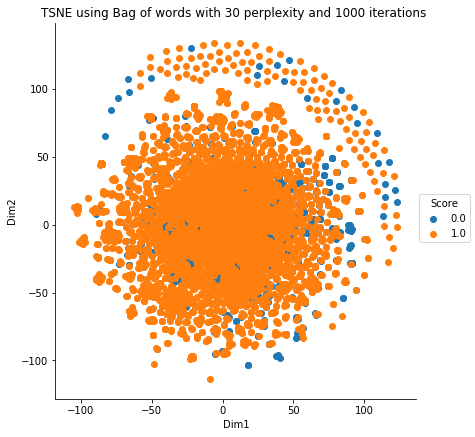

In [39]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    
from scipy.sparse import csr_matrix
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition
import seaborn as sn
pca = decomposition.PCA()

# BOW for New_Summary

count_vect1=sklearn.feature_extraction.text.CountVectorizer()
count_vect1.fit(lst)
bow_Summary1 = count_vect1.transform(lst)
print("The shape for Bag of Words vector is ")
print (bow_Summary1.shape)

#bigram,trigrams,ngrams for New_Summary

ngram_vect1 = sklearn.feature_extraction.text.CountVectorizer(ngram_range=(1,3))
ngram_Summary1 = ngram_vect1.fit_transform(lst2)
print("The shape for n-gram vector is ")
print (ngram_Summary1.shape)

#Step 1: Convert sparse to dense matrix
#https://stackoverflow.com/questions/16505670/generating-a-dense-matrix-from-a-sparse-matrix-in-numpy-python

bow_Summary_dense = bow_Summary1.todense()

#Step 2: standardize the data thus mean becomes 0 and std-dev is 1 
from sklearn.preprocessing import StandardScaler
bow_Summary_dense_std =StandardScaler().fit_transform(bow_Summary_dense)
print ("the shape of bow standardized matrix is ")
print (bow_Summary_dense_std.shape)

#Step 3 A: Creating a model with default perpexility
model_bow = TSNE(n_components = 2, random_state = 0)
tsne_bow = model_bow.fit_transform(bow_Summary_dense_std)
print ("the shape of tsne_bow vector is")
print (tsne_bow.shape)
tsne_bow = np.vstack((tsne_bow.T, data["Score"])).T
tsne_df = pd.DataFrame(data=tsne_bow, columns=("Dim1", "Dim2", "Score"))
sn.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.title("TSNE using Bag of words with 30 perplexity and 1000 iterations ")
plt.show()



## Note: For all the graphs we have Score as "0" or "1".
### 1 stands for positive Score
## 0 stands for negative Score

#### As dicussed we should never settle with just 1 TSNE plot we should change perplexity n iterations


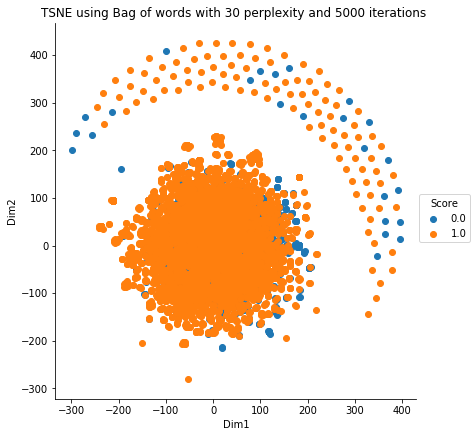

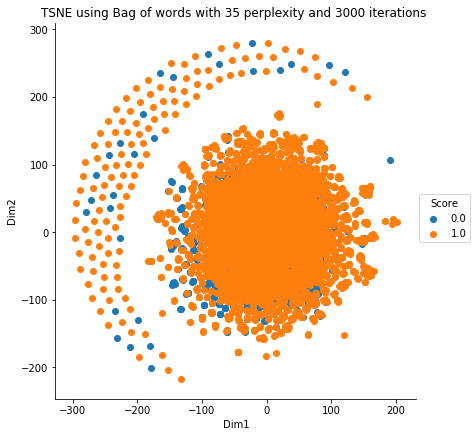

In [40]:

#Step 3 B: Creating graph for BOW with iterations 5000
model_bow_5k_iter = TSNE(n_components = 2, random_state=0,n_iter=5000)
tsne_bow_5k_iter = model_bow_5k_iter.fit_transform(bow_Summary_dense_std)
tsne_bow_5k_iter= np.vstack((tsne_bow_5k_iter.T,data["Score"])).T
tsne_df1 = pd.DataFrame(data=tsne_bow_5k_iter, columns=("Dim1", "Dim2", "Score"))
sn.FacetGrid(tsne_df1, hue="Score", size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.title("TSNE using Bag of words with 30 perplexity and 5000 iterations ")
plt.show()
###############################################################################
#Step 3 C: Creating graph with BOW with perplexity 35 and iterations 3000

model_bow_3k_iter_35perplex = TSNE(n_components = 2, perplexity = 35, random_state=0,n_iter=3000)
tsne_bow_3k_iter_35perplex = model_bow_3k_iter_35perplex.fit_transform(bow_Summary_dense_std)
tsne_bow_3k_iter_35perplex= np.vstack((tsne_bow_3k_iter_35perplex.T,data["Score"])).T
tsne_df2 = pd.DataFrame(data=tsne_bow_3k_iter_35perplex, columns=("Dim1", "Dim2", "Score"))
sn.FacetGrid(tsne_df2, hue="Score", size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.title("TSNE using Bag of words with 35 perplexity and 3000 iterations ")
plt.show()

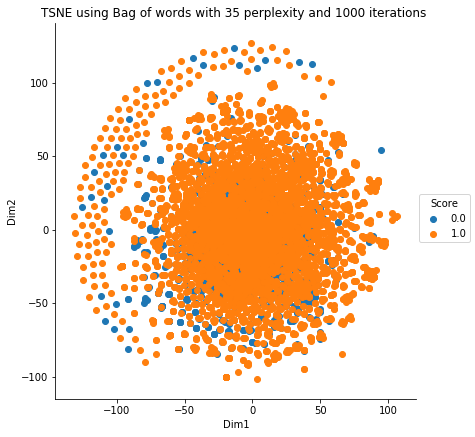

In [41]:
#Step 5 C: Creating graph with BOW with perplexity 35 and iterations 1000

model_bow_3k_iter_35perplex = TSNE(n_components = 2, random_state=0,perplexity=35)
tsne_bow_3k_iter_35perplex = model_bow_3k_iter_35perplex.fit_transform(bow_Summary_dense_std)
tsne_bow_3k_iter_35perplex= np.vstack((tsne_bow_3k_iter_35perplex.T,data["Score"])).T
tsne_df2 = pd.DataFrame(data=tsne_bow_3k_iter_35perplex, columns=("Dim1", "Dim2", "Score"))
sn.FacetGrid(tsne_df2, hue="Score", size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.title("TSNE using Bag of words with 35 perplexity and 1000 iterations ")
plt.show()

## [5.1] Applying TNSE on Text TFIDF vectors

The shape for TFIDF for vector is 
(6000, 25155)
the shape of tfidf standardized matrix is 
(6000, 25155)


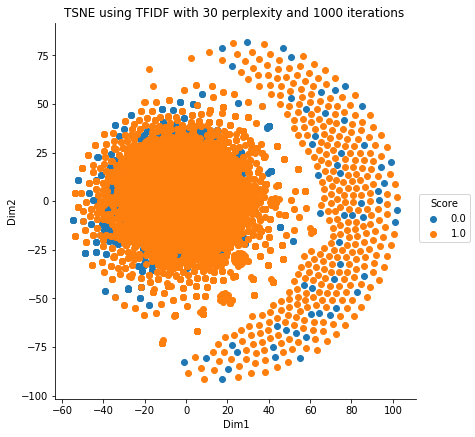

In [42]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

from scipy.sparse import csr_matrix
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition
import seaborn as sn
pca = decomposition.PCA()

#tfidf
tf_idf_vect = TfidfVectorizer(ngram_range=(1,3))
tf_idf_vect.fit(lst2)
tf_idf_Summary = tf_idf_vect.transform(lst2)
print("The shape for TFIDF for vector is ")
print (tf_idf_Summary.shape)

#Step 1: Convert sparse to dense matrix
#https://stackoverflow.com/questions/16505670/generating-a-dense-matrix-from-a-sparse-matrix-in-numpy-python

tfidf_Summary_dense = tf_idf_Summary.todense()

#Step 2: standardize the data thus mean becomes 0 and std-dev is 1 
from sklearn.preprocessing import StandardScaler
tfidf_Summary_dense_std =StandardScaler().fit_transform(tfidf_Summary_dense)
print ("the shape of tfidf standardized matrix is ")
print (tfidf_Summary_dense_std.shape)

#Step 3: Graph with default of 30 perplexity and 1K iterations

tfidf = TSNE(n_components = 2, random_state = 0)
tfidf_tsne = tfidf.fit_transform(tfidf_Summary_dense_std)
tfidf_tsne = np.vstack((tfidf_tsne.T, data["Score"])).T
tfidf_df = pd.DataFrame(data=tfidf_tsne, columns=("Dim1", "Dim2", "Score"))
sn.FacetGrid(tfidf_df, hue="Score", size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.title("TSNE using TFIDF with 30 perplexity and 1000 iterations ")
plt.show()

## [5.3] Applying TNSE on Text Avg W2V vectors

100%|███████████████████████████████████████████████████████████████████████████| 4986/4986 [00:00<00:00, 21485.08it/s]


the length of sent_vec is
4986


100%|███████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 17725.03it/s]


the len of sent_vectors1 is
6000


100%|███████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 14894.64it/s]


the len of sent_vectors2 is
6000
the shape of tsne vector is
(6000, 2)
the shape of data[score] vector is
(6000,)


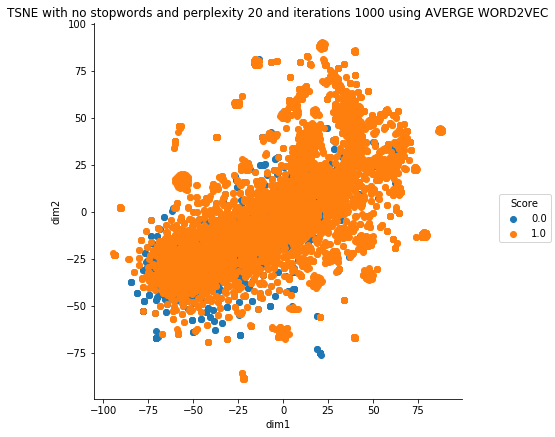

In [54]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
#Average-WordtoVec()

sent_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_original_code:
            vec = w2v_model_self_taught.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

print ("the length of sent_vec is")
print (len(sent_vectors))
############################################################################
sent_vectors1 = []
for sent1 in tqdm(lst_of_lst): # for each review/sentence
    sent_vec1 = np.zeros(50)
    cnt_words1 = 0
    for word1 in sent1:
        if word1 in w2v_words_no_stop:
            vec1 = w2v_model_self_taught1.wv[word1]
            sent_vec1 += vec1
            cnt_words1 += 1
    if cnt_words1 != 0:
        sent_vec1 /= cnt_words1
    sent_vectors1.append(sent_vec1)

print ("the len of sent_vectors1 is")
print (len(sent_vectors1))
###############################################################################
sent_vectors2 = []
for sent2 in tqdm(lst_of_lst_with_stop): # for each review/sentence
    sent_vec2 = np.zeros(50)
    cnt_words2 = 0
    for word2 in sent2:
        if word2 in w2v_words_with_stop:
            vec2 = w2v_model_self_taught2.wv[word2]
            sent_vec2 += vec2
            cnt_words2 += 1
    if cnt_words2 != 0:
        sent_vec2 /= cnt_words2
    sent_vectors2.append(sent_vec2)

print ("the len of sent_vectors2 is")
print (len(sent_vectors2))

###############################################################################
"""
sum_vectors3 = []
for sent2 in tqdm(lst_of_lst_2): # for each review/sentence

sum_vec3 = np.zeros(300)
count = 0
for word3 in sent3:
    vec3 = w2v_model_google.wv[word]
    sent_vec3 += vec3
    cnt_words3 += 1
if cnt_words3 != 0:
    sent_vec3 /= cnt_words3
sent_vectors3.append(sent_vec3)"""

model_avg_w2v_no_stop = TSNE(n_components =2,random_state=0,perplexity=20,n_iter=1000)
tsne_avg_w2v_no_stop = model_avg_w2v_no_stop.fit_transform(sent_vectors1)
print ("the shape of tsne vector is")
print (tsne_avg_w2v_no_stop.shape)
print ("the shape of data[score] vector is")
print (data["Score"].shape)
tsne_avg_w2v_no_stop = np.vstack((tsne_avg_w2v_no_stop.T,data["Score"])).T
tsne_avg_w2v_no_stop_dataframe = pd.DataFrame(data=tsne_avg_w2v_no_stop,columns =("dim1","dim2","Score"))
sn.FacetGrid(tsne_avg_w2v_no_stop_dataframe,hue="Score",size =6).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("TSNE with no stopwords and perplexity 20 and iterations 1000 using AVERGE WORD2VEC")
plt.show()

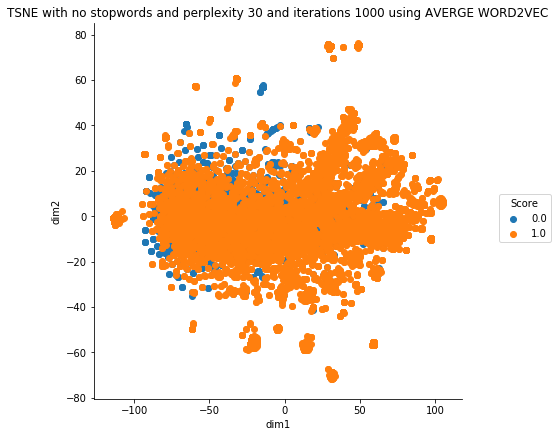

In [55]:
model_avg_w2v_no_stop = TSNE(n_components =2,random_state=0,perplexity=30,n_iter=1000)
tsne_avg_w2v_no_stop = model_avg_w2v_no_stop.fit_transform(sent_vectors1)
tsne_avg_w2v_no_stop = np.vstack((tsne_avg_w2v_no_stop.T,data["Score"])).T
tsne_avg_w2v_no_stop_dataframe = pd.DataFrame(data=tsne_avg_w2v_no_stop,columns =("dim1","dim2","Score"))
sn.FacetGrid(tsne_avg_w2v_no_stop_dataframe,hue="Score",size =6).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("TSNE with no stopwords and perplexity 30 and iterations 1000 using AVERGE WORD2VEC")
plt.show()

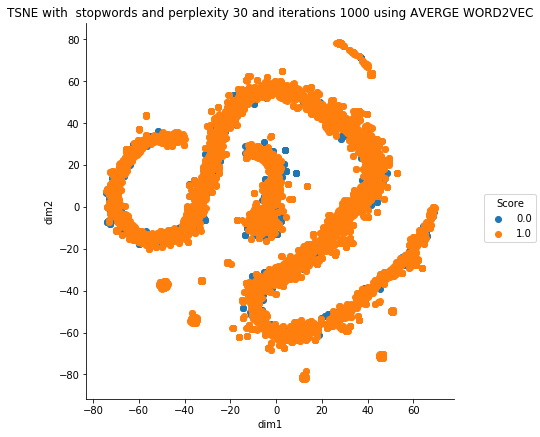

In [56]:
model_avg_w2v_with_stop = TSNE(n_components =2,random_state=0,perplexity=30,n_iter=1000)
tsne_avg_w2v_with_stop = model_avg_w2v_with_stop.fit_transform(sent_vectors2)
tsne_avg_w2v_with_stop = np.vstack((tsne_avg_w2v_with_stop.T,data["Score"])).T
tsne_avg_w2v_with_stop_dataframe = pd.DataFrame(data=tsne_avg_w2v_with_stop,columns =("dim1","dim2","Score"))
sn.FacetGrid(tsne_avg_w2v_with_stop_dataframe,hue="Score",size =6).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("TSNE with  stopwords and perplexity 30 and iterations 1000 using AVERGE WORD2VEC")
plt.show()

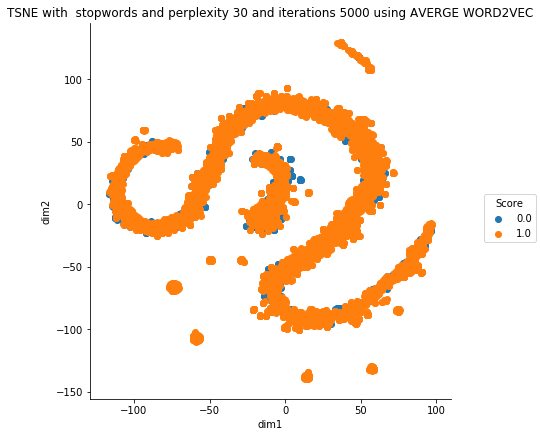

In [57]:
model_avg_w2v_with_stop = TSNE(n_components =2,random_state=0,perplexity=30,n_iter=5000)
tsne_avg_w2v_with_stop = model_avg_w2v_with_stop.fit_transform(sent_vectors2)
tsne_avg_w2v_with_stop = np.vstack((tsne_avg_w2v_with_stop.T,data["Score"])).T
tsne_avg_w2v_with_stop_dataframe = pd.DataFrame(data=tsne_avg_w2v_with_stop,columns =("dim1","dim2","Score"))
sn.FacetGrid(tsne_avg_w2v_with_stop_dataframe,hue="Score",size =6).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("TSNE with  stopwords and perplexity 30 and iterations 5000 using AVERGE WORD2VEC")
plt.show()

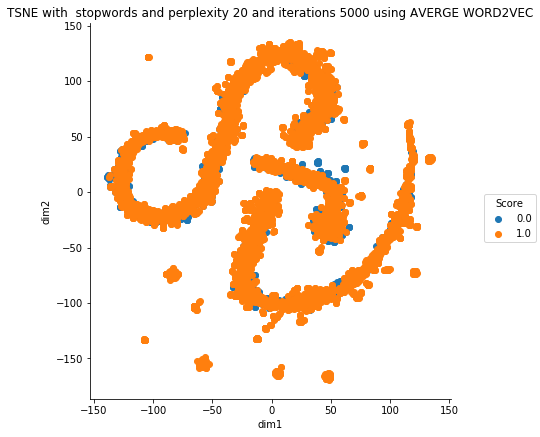

In [58]:
model_avg_w2v_with_stop = TSNE(n_components =2,random_state=0,perplexity=20,n_iter=5000)
tsne_avg_w2v_with_stop = model_avg_w2v_with_stop.fit_transform(sent_vectors2)
tsne_avg_w2v_with_stop = np.vstack((tsne_avg_w2v_with_stop.T,data["Score"])).T
tsne_avg_w2v_with_stop_dataframe = pd.DataFrame(data=tsne_avg_w2v_with_stop,columns =("dim1","dim2","Score"))
sn.FacetGrid(tsne_avg_w2v_with_stop_dataframe,hue="Score",size =6).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("TSNE with  stopwords and perplexity 20 and iterations 5000 using AVERGE WORD2VEC")
plt.show()

## [5.4] Applying TNSE on Text TFIDF weighted W2V vectors

100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:01<00:00, 4740.47it/s]


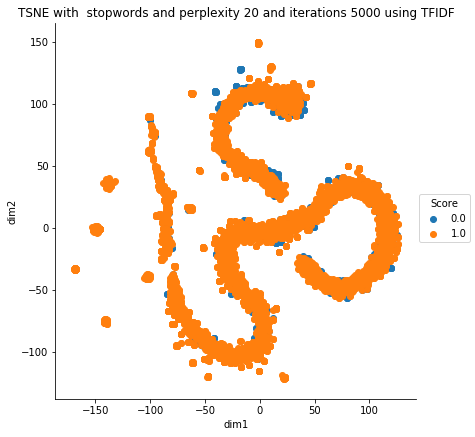

In [67]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

model = TfidfVectorizer()
model.fit(sum_val_with_stop)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent4 in tqdm(lst_of_lst_with_stop): # for each review/sentence 
    sent_vec4 = np.zeros(50) # as word vectors are of zero length
    weight_sum4 =0; # num of words with a valid vector in the sentence/review
    for word4 in sent4: # for each word in a review/sentence
        if word4 in w2v_words_with_stop and word4 in tfidf_feat:
            vec4 = w2v_model_self_taught2.wv[word4]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word4]*(sent4.count(word4)/len(sent4))
            sent_vec4 += (vec4 * tf_idf)
            weight_sum4 += tf_idf
    if weight_sum4 != 0:
        sent_vec4 /= weight_sum4
    tfidf_sent_vectors.append(sent_vec4)
    row += 1

model_tfidf_w2v_with_stop = TSNE(n_components =2,random_state=0,perplexity=20,n_iter=5000)
tsne_tfidf_with_stop = model_tfidf_w2v_with_stop.fit_transform(tfidf_sent_vectors)
tsne_tfidf_with_stop = np.vstack((tsne_tfidf_with_stop.T,data["Score"])).T
tsne_tfidf_with_stop_dataframe = pd.DataFrame(data=tsne_tfidf_with_stop,columns =("dim1","dim2","Score"))
sn.FacetGrid(tsne_tfidf_with_stop_dataframe,hue="Score",size =6).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("TSNE with  stopwords and perplexity 20 and iterations 5000 using TFIDF")
plt.show()

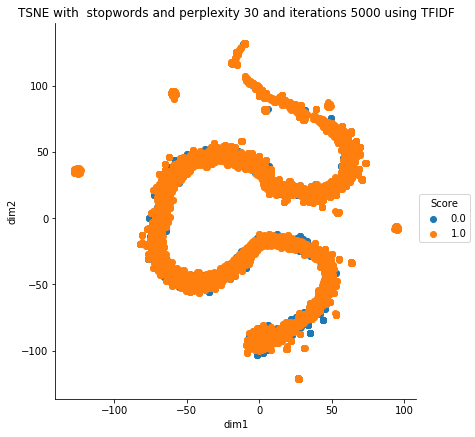

In [68]:
model_tfidf_w2v_with_stop = TSNE(n_components =2,random_state=0,perplexity=30,n_iter=5000)
tsne_tfidf_with_stop = model_tfidf_w2v_with_stop.fit_transform(tfidf_sent_vectors)
tsne_tfidf_with_stop = np.vstack((tsne_tfidf_with_stop.T,data["Score"])).T
tsne_tfidf_with_stop_dataframe = pd.DataFrame(data=tsne_tfidf_with_stop,columns =("dim1","dim2","Score"))
sn.FacetGrid(tsne_tfidf_with_stop_dataframe,hue="Score",size =6).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("TSNE with  stopwords and perplexity 30 and iterations 5000 using TFIDF")
plt.show()

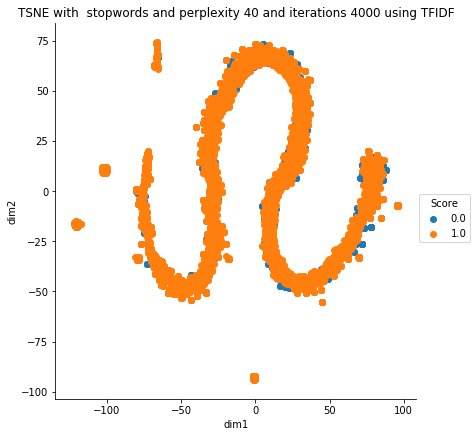

In [69]:
model_tfidf_w2v_with_stop = TSNE(n_components =2,random_state=0,perplexity=40,n_iter=4000)
tsne_tfidf_with_stop = model_tfidf_w2v_with_stop.fit_transform(tfidf_sent_vectors)
tsne_tfidf_with_stop = np.vstack((tsne_tfidf_with_stop.T,data["Score"])).T
tsne_tfidf_with_stop_dataframe = pd.DataFrame(data=tsne_tfidf_with_stop,columns =("dim1","dim2","Score"))
sn.FacetGrid(tsne_tfidf_with_stop_dataframe,hue="Score",size =6).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("TSNE with  stopwords and perplexity 40 and iterations 4000 using TFIDF")
plt.show()

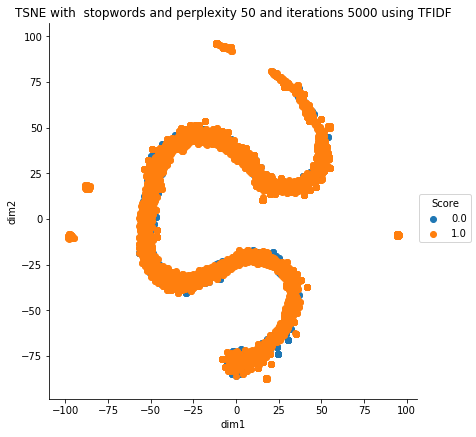

In [70]:
model_tfidf_w2v_with_stop = TSNE(n_components =2,random_state=0,perplexity=50,n_iter=5000)
tsne_tfidf_with_stop = model_tfidf_w2v_with_stop.fit_transform(tfidf_sent_vectors)
tsne_tfidf_with_stop = np.vstack((tsne_tfidf_with_stop.T,data["Score"])).T
tsne_tfidf_with_stop_dataframe = pd.DataFrame(data=tsne_tfidf_with_stop,columns =("dim1","dim2","Score"))
sn.FacetGrid(tsne_tfidf_with_stop_dataframe,hue="Score",size =6).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("TSNE with  stopwords and perplexity 50 and iterations 5000 using TFIDF")
plt.show()

100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 7189.05it/s]


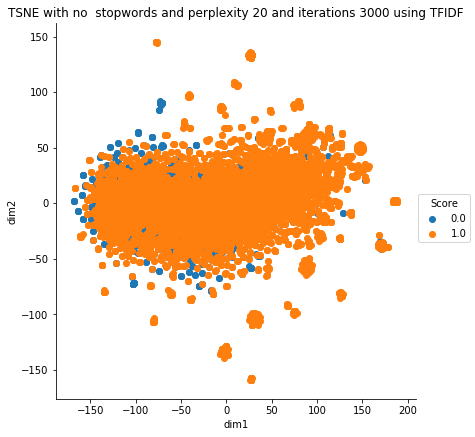

In [71]:
model = TfidfVectorizer()
model.fit(new_sum_val)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent3 in tqdm(lst_of_lst): # for each review/sentence 
    sent_vec3 = np.zeros(50) # as word vectors are of zero length
    weight_sum3 =0; # num of words with a valid vector in the sentence/review
    for word3 in sent3: # for each word in a review/sentence
        if word3 in w2v_words_no_stop and word3 in tfidf_feat:
            vec3 = w2v_model_self_taught1.wv[word3]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word3]*(sent3.count(word3)/len(sent3))
            sent_vec3 += (vec3 * tf_idf)
            weight_sum3 += tf_idf
    if weight_sum3 != 0:
        sent_vec3 /= weight_sum3
    tfidf_sent_vectors.append(sent_vec3)
    row += 1
    
model_tfidf_w2v_no_stop = TSNE(n_components =2,random_state=0,perplexity=20,n_iter=3000)
tsne_tfidf_no_stop = model_tfidf_w2v_no_stop.fit_transform(tfidf_sent_vectors)
tsne_tfidf_no_stop = np.vstack((tsne_tfidf_no_stop.T,data["Score"])).T
tsne_tfidf_no_stop_dataframe = pd.DataFrame(data=tsne_tfidf_no_stop,columns =("dim1","dim2","Score"))
sn.FacetGrid(tsne_tfidf_no_stop_dataframe,hue="Score",size =6).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("TSNE with no  stopwords and perplexity 20 and iterations 3000 using TFIDF")
plt.show()

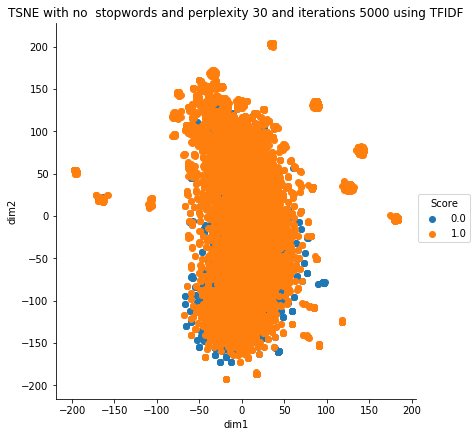

In [72]:
model_tfidf_w2v_no_stop = TSNE(n_components =2,random_state=0,perplexity=30,n_iter=5000)
tsne_tfidf_no_stop = model_tfidf_w2v_no_stop.fit_transform(tfidf_sent_vectors)
tsne_tfidf_no_stop = np.vstack((tsne_tfidf_no_stop.T,data["Score"])).T
tsne_tfidf_no_stop_dataframe = pd.DataFrame(data=tsne_tfidf_no_stop,columns =("dim1","dim2","Score"))
sn.FacetGrid(tsne_tfidf_no_stop_dataframe,hue="Score",size =6).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("TSNE with no  stopwords and perplexity 30 and iterations 5000 using TFIDF")
plt.show()

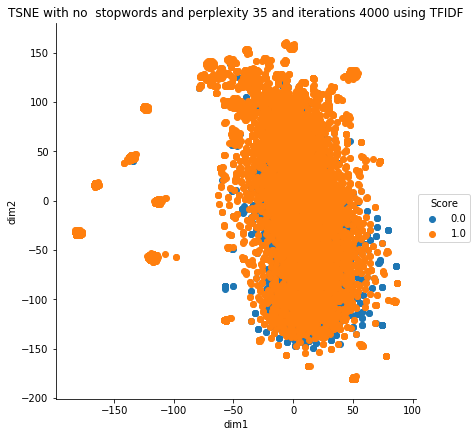

In [73]:
model_tfidf_w2v_no_stop = TSNE(n_components =2,random_state=0,perplexity=35,n_iter=4000)
tsne_tfidf_no_stop = model_tfidf_w2v_no_stop.fit_transform(tfidf_sent_vectors)
tsne_tfidf_no_stop = np.vstack((tsne_tfidf_no_stop.T,data["Score"])).T
tsne_tfidf_no_stop_dataframe = pd.DataFrame(data=tsne_tfidf_no_stop,columns =("dim1","dim2","Score"))
sn.FacetGrid(tsne_tfidf_no_stop_dataframe,hue="Score",size =6).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("TSNE with no  stopwords and perplexity 35 and iterations 4000 using TFIDF")
plt.show()

# [6] Conclusions

In [74]:
# Write few sentance about the results that you got and observation that you did from the analysis


#### So for conclusion : It is very to predict or make some very strong inference out of the above plots(graph). 

It is very difficult to mark for either positive or negative reviews the kind of words used. It is both mixed and we can't make a line (since all oor tSNE plot are 2D)which distinguished blue (negative score review) and orange (+ve score review)